Размноживание данных для нейронной сети

In [11]:
import random
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns

from scipy import signal
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

In [2]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = data # signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel

In [3]:
def fake_pulse(pulse, amp):
    return_pulse = []
    for i in pulse:
        if i != 0:
            return_pulse.append(i+ np.random.uniform(-amp, amp))
        else:
            return_pulse.append(0)
    return return_pulse


def new_pulse(pulse):
    amp_pls = np.std(pulse[:20])/3
    return (pulse
            + np.random.normal(loc=0.0, scale=amp_pls, size=len(pulse))
            - np.random.normal(loc=0.0, scale=amp_pls, size=len(pulse)))


def screan(t, t_s):
    if t < 0:
        return 0
    else:
        return np.exp(-t/t_s)


def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [4]:
gp_table = pd.read_table('typized_dataset_for_dina_2020-03-11.csv', sep='\t')

T_SCATTERING = 15.85

In [5]:
# Разделение набора данных на помехи и импульсы
noises = gp_table[gp_table.type == 0]
pulses = gp_table[gp_table.type == 1]
print(len(noises), len(pulses))
# случайная сортировка
noises = noises.sample(len(noises)).reset_index(drop=True)
pulses = pulses.sample(len(pulses)).reset_index(drop=True)
# выделение данных для итогового теста
break_point_noise = int(len(noises)/3)
break_point_pulse = int(len(pulses)/3)
noise_final_test, noise_to_train = noises[:break_point_noise], noises[break_point_noise:]
pulses_final_test, pulses_to_train = pulses[:break_point_pulse], pulses[break_point_pulse:]

128 1576


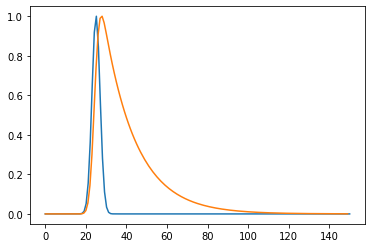

In [7]:
x = np.linspace(0, 150, 150)
gs = gauss(x, 0.1, 25, 2)
scr = [screan(i, T_SCATTERING) for i in x] 
plt.plot(x, gs/max(gs))
plt.plot(np.convolve(gs, scr,'full')[:150]/max(np.convolve(scr, gs)))
plt.show()

In [6]:
def my_pulse(x,a,x0,sigma, t_s):
    gs = gauss(x, a, x0, sigma)
    scr = [screan(i, t_s) for i in x] 
    return np.convolve(scr, gs, 'full')[:150]

## План
+ Создаем базу для новых импульсов
+ Берется импульс из базы оригинальных
+ Определяется амплитуда шумов импульса в начале записи
+ Импульс фитируется 
+ На фитинг накладывается шум с уже определенной амплитудой (10 раз)
+ Каждый размноженый импульс сохраняется в новую базу.
+ Произвести сравнение основных и сгенерированных импульсов

In [31]:
pulses_mega_pack = pd.DataFrame(columns=pulses.columns)
noises_mega_pack = pd.DataFrame(columns=noises.columns)

In [32]:
full_index = 0
for idx, row in pulses_to_train.iterrows():
    x = np.linspace(0, 150, 150)
    y = np.asarray(pulses_to_train.loc[idx][:-1])
    
    # выравнивение импульса относительно 0
    y -= np.median(y[:11])
    # Определение амплитуды шума
    ampl_noise = np.std(y[:11])
    
    amp = 1
    mean = 25
    sigma = 3
    t_s = 10
    
    try:
        popt,pcov = curve_fit(my_pulse,x,y,p0=[amp,mean,sigma, t_s])
        new_pulse = my_pulse(x,*popt)

    except RuntimeError:
        continue
    
    for _ in range(10):
        noise = np.random.normal(0, ampl_noise, len(new_pulse))
        new_pulse_to_table = new_pulse + noise
        pulses_mega_pack.loc[full_index] = [*new_pulse_to_table, 1]
        full_index += 1

c:\users\professional\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


In [34]:
# creating addition dataset for noises
count = 0
for j in noise_to_train.index:
    for i in range(100):
        test_pulse = list(noise_to_train.loc[j][:-1])
        std_end_pulse = 0.13
        fk_pulse = fake_pulse(test_pulse, std_end_pulse)
        noises_mega_pack.loc[count] = [*fk_pulse, 0]
        count += 1

In [35]:
# For vizualization
real_pulse_start_std = []
real_pulse_end_std = []
real_pulse_full_std = []

fake_pulse_start_std = []
fake_pulse_end_std = []
fake_pulse_full_std = []

real_noise_start_std = []
real_noise_end_std = []
real_noise_full_std = []

fake_noise_start_std = []
fake_noise_end_std = []
fake_noise_full_std = []

for idx, row in enumerate(pulses.iterrows()):
    real_pulse_start_std.append(np.std(row[1][0:20]))
    real_pulse_end_std.append(np.std(row[1][-30:-1]))
    real_pulse_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(pulses_mega_pack.iterrows()):
    fake_pulse_start_std.append(np.std(row[1][0:20]))
    fake_pulse_end_std.append(np.std(row[1][-30:-1]))
    fake_pulse_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(noises.iterrows()):
    real_noise_start_std.append(np.std(row[1][0:20]))
    real_noise_end_std.append(np.std(row[1][-30:-1]))
    real_noise_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(noises_mega_pack.iterrows()):
    fake_noise_start_std.append(np.std(row[1][0:20]))
    fake_noise_end_std.append(np.std(row[1][-30:-1]))
    fake_noise_full_std.append(np.std(row[1][:-1]))

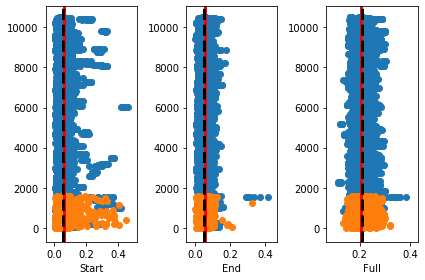

In [36]:
plt.close()
plt.subplot(1, 3, 1)
plt.xlabel('Start')
plt.scatter(fake_pulse_start_std,range(len(fake_pulse_start_std)))
plt.scatter(real_pulse_start_std, range(len(real_pulse_start_std)))
plt.axvline(np.mean(real_pulse_start_std), lw=3, color='r')
plt.axvline(np.mean(fake_pulse_start_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 2)
plt.xlabel('End')
plt.scatter(fake_pulse_end_std, range(len(fake_pulse_end_std)))
plt.scatter(real_pulse_end_std, range(len(real_pulse_end_std)))
plt.axvline(np.mean(real_pulse_end_std), lw=3, color='r')
plt.axvline(np.mean(fake_pulse_end_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 3)
plt.xlabel('Full')
plt.scatter(fake_pulse_full_std, range(len(fake_pulse_full_std)))
plt.scatter(real_pulse_full_std, range(len(real_pulse_full_std)))
plt.axvline(np.mean(real_pulse_full_std), lw=3, color='r')
plt.axvline(np.mean(fake_pulse_full_std), lw=3, color='black', ls='--')
plt.tight_layout()
plt.show()

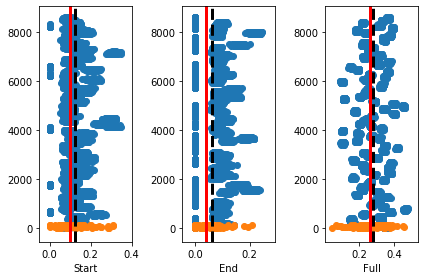

In [37]:
plt.close()
plt.subplot(1, 3, 1)
plt.xlabel('Start')
plt.scatter(fake_noise_start_std,range(len(fake_noise_start_std)))
plt.scatter(real_noise_start_std, range(len(real_noise_start_std)))
plt.axvline(np.mean(real_noise_start_std), lw=3, color='r')
plt.axvline(np.mean(fake_noise_start_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 2)
plt.xlabel('End')
plt.scatter(fake_noise_end_std, range(len(fake_noise_end_std)))
plt.scatter(real_noise_end_std, range(len(real_noise_end_std)))
plt.axvline(np.mean(real_noise_end_std), lw=3, color='r')
plt.axvline(np.mean(fake_noise_end_std), lw=3, color='black', ls='--')
plt.subplot(1, 3, 3)
plt.xlabel('Full')
plt.scatter(fake_noise_full_std, range(len(fake_noise_full_std)))
plt.scatter(real_noise_full_std, range(len(real_noise_full_std)))
plt.axvline(np.mean(real_noise_full_std), lw=3, color='r')
plt.axvline(np.mean(fake_noise_full_std), lw=3, color='black', ls='--')
plt.tight_layout()
plt.show()

In [38]:
# combine packs together
result_frame = pd.concat([pulses_to_train, noise_to_train, pulses_mega_pack, noises_mega_pack])

In [39]:
result_frame = result_frame.reset_index(drop=True)

In [40]:
result_frame = result_frame.sample(len(result_frame)).reset_index(drop=True)

In [41]:
result_frame

,point_0,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_141,point_142,point_143,point_144,point_145,point_146,point_147,point_148,point_149,type
0,-0.107425,-0.040054,0.027209,-0.095446,-0.032294,-0.044857,-0.030011,0.067417,0.019192,-0.088490,...,0.287468,0.307765,0.205899,0.292981,0.044746,0.145179,0.182721,0.033172,0.077281,0.0
1,0.372199,0.414994,0.462996,0.086225,0.169555,0.519417,0.491496,0.507067,0.316374,0.399203,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.049818,-0.030785,-0.042379,0.058709,-0.051080,-0.104343,-0.063281,0.107516,0.264450,0.213073,...,-0.126240,-0.189979,-0.149404,-0.168188,0.030842,-0.087133,-0.004591,-0.118140,-0.208254,0.0
3,-0.117339,0.034344,0.083454,0.042894,-0.019645,0.213182,0.290765,0.179973,0.099662,-0.017555,...,-0.010853,-0.033128,-0.009526,0.113979,0.180951,0.009532,0.004041,0.127695,-0.003278,0.0
4,-0.039921,-0.026111,0.120290,-0.056674,0.077556,-0.041396,-0.051609,0.053507,0.028466,-0.032710,...,0.174287,0.196566,0.077120,0.042491,0.072757,0.087268,0.001433,0.079748,0.165581,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20242,0.049029,-0.039183,-0.001306,0.009938,-0.009380,-0.031126,0.062328,0.002047,-0.032223,-0.003341,...,-0.044986,0.002882,-0.022733,-0.056697,-0.020783,-0.036389,-0.014559,-0.014577,-0.020836,1.0
20243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.060185,-0.067656,0.065816,-0.070227,-0.118800,0.115492,0.076708,0.071030,0.013024,0.0
20244,-0.046184,0.158348,0.194189,0.054463,-0.012793,-0.037226,-0.144485,0.055849,0.096725,0.041886,...,0.227631,0.253279,0.181244,0.300415,0.265161,0.305819,0.210464,0.159070,0.327511,0.0
20245,-0.012763,-0.013509,-0.037475,-0.011305,-0.064315,-0.018253,-0.061333,-0.150786,-0.029445,0.065158,...,-0.045468,-0.061412,-0.059032,-0.003145,0.083953,0.028710,0.027081,0.050859,0.043946,1.0


In [44]:
NOW = datetime.datetime.now().strftime("%Y-%m-%d")

In [45]:
result_frame.to_csv(f'typized_dataset_for_dina_megaset_{NOW}.csv', sep='\t', header=True, index=False)

In [46]:
# сохранить итоговую таблицу для теста
test_frame = pd.concat([noise_final_test, pulses_final_test])
test_frame = test_frame.reset_index(drop=True)
test_frame = test_frame.sample(len(test_frame)).reset_index(drop=True)
test_frame.to_csv(
    f'typized_dataset_for_dina_final_test_{NOW}.csv', sep='\t', header=True, index=False)

### Отрисовка импульсов и помех

In [166]:
idx = 600
x = np.linspace(0, 150, 150)
y = np.asarray(pulses_to_train.loc[idx][:-1])

# выравнивение импульса относительно 0
y -= np.median(y[:11])
# Определение амплитуды шума
ampl_noise = np.std(y[:11])

amp = 1
mean = 25
sigma = 3
t_s = 10

try:
    popt,pcov = curve_fit(my_pulse,x,y,p0=[amp,mean,sigma, t_s])
    new_pulse = my_pulse(x,*popt)

except RuntimeError:
    print('Error')

noise = np.random.normal(0, ampl_noise, len(new_pulse))
new_pulse_to_table = new_pulse + noise

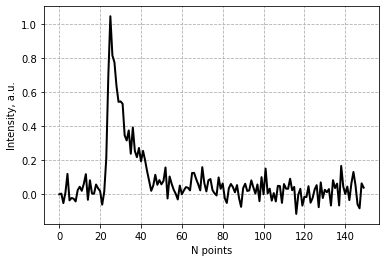

In [167]:
plt.clf()
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.plot(y, color='black', lw=2)
plt.grid(True, ls='--')
plt.savefig(f'./some_images/{idx}_real_pulse.png', format='png', dpi=700)

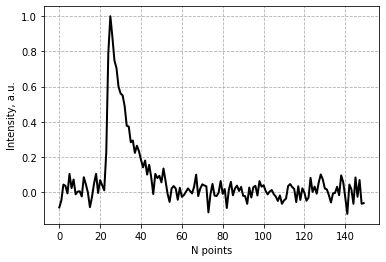

In [168]:
plt.clf()
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.plot(new_pulse_to_table/max(new_pulse_to_table), color='black', lw=2)
plt.grid(True, ls='--')
plt.savefig(f'./some_images/{idx}_fake_pulse.png', format='png', dpi=700)

In [157]:
j = 43
test_pulse = list(noise_to_train.loc[j][:-1])
std_end_pulse = 0.13
fk_pulse = fake_pulse(test_pulse, std_end_pulse)

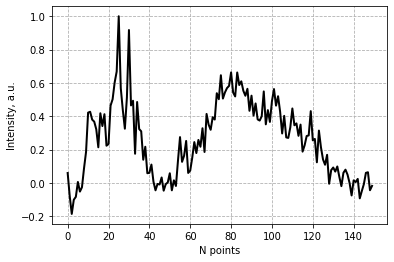

In [158]:
plt.clf()
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.plot(test_pulse, color='black', lw=2)
plt.grid(True, ls='--')
plt.savefig(f'./some_images/{j}_real_noise.png', format='png', dpi=700)

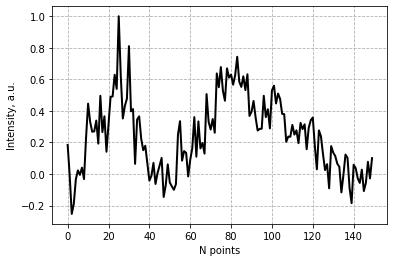

In [159]:
plt.clf()
plt.ylabel('Intensity, a.u.')
plt.xlabel('N points')
plt.plot(fk_pulse/np.max(fk_pulse), color='black', lw=2)
plt.grid(True, ls='--')
plt.savefig(f'./some_images/{j}_fake_noise.png', format='png', dpi=700)